# Class prototype

In [1]:
import tensorflow as tf
import numpy as np
import gzip
import keras
import matplotlib.pyplot as plt
import time
import random
from sklearn.gaussian_process.kernels import PairwiseKernel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessRegressor
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, Adam, Nadam

Using TensorFlow backend.


Get MNIST

In [2]:
np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)

# read data set
f = gzip.open('./data/train-images-idx3-ubyte.gz', 'rb')
x_train = np.array(np.frombuffer(f.read(), np.uint8, offset=16))

f = gzip.open('./data/train-labels-idx1-ubyte.gz', 'rb')
y_train = np.array(np.frombuffer(f.read(), np.uint8, offset=8))

f = gzip.open('./data/t10k-images-idx3-ubyte.gz', 'rb')
x_test = np.array(np.frombuffer(f.read(), np.uint8, offset=16))

f = gzip.open('./data/t10k-labels-idx1-ubyte.gz', 'rb')
y_test = np.array(np.frombuffer(f.read(), np.uint8, offset=8))

# data preprocessing
x_train = np.reshape(x_train, (-1, 784))
x_train = x_train / 255
x_train = x_train.astype(np.float32)
x_test = np.reshape(x_test, (-1, 784))
x_test = x_test / 255
x_test = x_test.astype(np.float32)

# get each training images
idx_train = [0 for i in range(10)]
idx_test = [0 for i in range(10)]
for i in range(10):
    idx_train[i] = (y_train == i)
    idx_test[i] = (y_test == i)
      
x_train_38 = x_train[idx_train[3]+idx_train[8]][0:1000]
x_test_38 = x_test[idx_test[3]+idx_test[8]][0:200]   

# y_train_38 = y_train[idx_train[3]+idx_train[8]][0:1000]
# print(np.count_nonzero(y_train_38[y_train_38==3]))

# one-hot encoding
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)


y_train_38 = y_train[idx_train[3]+idx_train[8]][0:1000]
y_test_38 = y_test[idx_test[3]+idx_test[8]][0:200] 

In [3]:
# K-Means clustering to find centers
start = time.time()
kmeans_model = KMeans(2)
kmeans_model.fit(x_train[idx_train[8]+idx_train[3]])
_38=np.reshape(kmeans_model.cluster_centers_,(-1,784))
print("Cluster Production time(sec) :", time.time() - start)
# x_model = KMeans(100)
# x_model.fit(x_train)
# x = x_model.predict(x_model.cluster_centers_)
# x = keras.utils.to_categorical(x,100)

x = np.zeros((2,2))
for i in range(2):
    x[i][i] = 1

Cluster Production time(sec) : 4.471498966217041


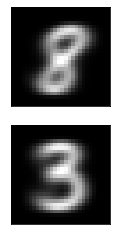

In [4]:
fig = plt.figure()

for i in range(2):
  subplot = fig.add_subplot(2,1, i+1)
  subplot.set_xticks([])
  subplot.set_yticks([])
  subplot.imshow(np.reshape(_38[i], (28, 28)), cmap='gray')

In [5]:
row = [random.randrange(0,22) for i in range(50)]
col = [random.randrange(0,22) for i in range(50)]
train_label=[]
train_image =[]
test_image=[]
test_label=[]

centers =[]

for i in range(50):
    for cluster in _38:
        centers.extend(cluster[r*28+col[i] : r*28+(col[i]+7) ] for r in range(row[i],row[i]+7))
centers = np.reshape(centers,(-1,49))

print(centers.shape)



for j in range(50):
    for i in range(1000):
        train_image.extend(x_train_38[i][r*28+col[j] : r*28+(col[j]+7) ] for r in range(row[j],row[j]+7))
        train_label.extend(y_train_38[i])
train_image = np.reshape(train_image,(-1,49))
train_label = np.reshape(train_label,(-1,10))
print(train_image.shape)

for j in range(50):
    for i in range(200):
        test_image.extend(x_test_38[i][r*28+col[j] : r*28+(col[j]+7) ] for r in range(row[j],row[j]+7))
        test_label.extend(y_test_38[i])    
test_image = np.reshape(test_image,(-1,49))
test_label = np.reshape(test_label,(-1,10))
                                                                                                                                                                                                                                            
# train_random = np.arange(train_image.shape[0])
# np.random.shuffle(train_random)
# test_random = np.arange(test_image.shape[0])
# np.random.shuffle(test_random)

# train_image = train_image[train_random]
# train_label = train_label[train_random]
# test_image = test_image[test_random]
# test_label = test_label[test_random]


(100, 49)
(50000, 49)


In [6]:
# # plot cluster centers as images
# imgs = centers * 255
# fig = plt.figure(figsize =(5,100))
# for i in range(50):
#   subplot = fig.add_subplot(50,2, 2*i+1)
#   subplot.imshow(np.reshape(centers[i], (7, 7)), cmap='gray')
#   subplot = fig.add_subplot(50,2, 2*i+2)
#   subplot.imshow(np.reshape(centers[i+50], (7, 7)), cmap='gray')
  
# plt.savefig('rbf_centers.png')


In [7]:

class Model:
    
    def __init__(self, m_train_image, m_test_image, m_train_label , m_test_label):
        self.m_train_image = m_train_image
        self.m_test_image = m_test_image
        self.m_train_label = m_train_label
        self.m_test_label = m_test_label
        self.temp1 = None
        self.temp2 = None
        self.model = None
        self.predict_value =[]
        
    
    def _RBF(self, m_centers, m_x, segment):
        # RBF Layer
        kernel = PairwiseKernel(metric='polynomial') 
        rbf_model = GaussianProcessRegressor(kernel=kernel,alpha=0.1).fit(m_centers[2*segment:2*(segment+1)], m_x)

        self.temp1 = rbf_model.predict(self.m_train_image)
        self.temp2 = rbf_model.predict(self.m_test_image)


    def _Perceptron(self):
        # Perceptron Layers
        batch_size = 100
        epochs = 100

        self.model = Sequential()
        self.model.add(Dense(10, activation='softmax', input_shape=(2,)))

        self.model.summary()
        nadam=keras.optimizers.Nadam(lr=0.0005)
        self.model.compile(loss='categorical_crossentropy',
                      optimizer=nadam,
                      metrics=['accuracy'])


        # Train model
        history = self.model.fit(self.temp1, self.m_train_label,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1)
    def _Predict(self):
        predictions = self.model.predict(self.temp2)

        return predictions

In [20]:
models = []
for m in range(50):
    models.append(Model(train_image[m*1000:(m+1)*1000],test_image[m*200:(m+1)*200],
                        train_label[m*1000:(m+1)*1000],test_image[m*200:(m+1)*200]))

In [23]:
cnt = 0
softmax_sum = np.ones((200,10))
for m in models:
    m._RBF(centers,x,cnt)
    m._Perceptron()
#     softmax_sum += m._Predict()
#     cnt +=1


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1000/1000 [==============================] - 1s 1ms/step - loss: 2.5194 - acc: 0.0100
Epoch 2/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.5029 - acc: 0.0150
Epoch 3/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.4852 - acc: 0.0270
Epoch 4/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.4670 - acc: 0.0370
Epoch 5/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.4487 - acc: 0.0420
Epoch 6/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.4304 - acc: 0.0530
Epoch 7/100
1000/1000 [==============================] - 0s 18us/step - loss: 2.4

1000/1000 [==============================] - 0s 19us/step - loss: 1.8106 - acc: 0.5280
Epoch 55/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.8017 - acc: 0.5290
Epoch 56/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.7928 - acc: 0.5310
Epoch 57/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.7841 - acc: 0.5320
Epoch 58/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.7753 - acc: 0.5350
Epoch 59/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.7667 - acc: 0.5390
Epoch 60/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.7581 - acc: 0.5400
Epoch 61/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.7496 - acc: 0.5400
Epoch 62/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.7412 - acc: 0.5410
Epoch 63/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.7329 - acc: 0.5410
Epoch 64/100


1000/1000 [==============================] - 0s 19us/step - loss: 2.2252 - acc: 0.3520
Epoch 9/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.2151 - acc: 0.3800
Epoch 10/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.2050 - acc: 0.4070
Epoch 11/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.1950 - acc: 0.4310
Epoch 12/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.1850 - acc: 0.4480
Epoch 13/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.1751 - acc: 0.4550
Epoch 14/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.1652 - acc: 0.4610
Epoch 15/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.1554 - acc: 0.4670
Epoch 16/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.1456 - acc: 0.4720
Epoch 17/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.1359 - acc: 0.4720
Epoch 18/100
1

1000/1000 [==============================] - 0s 20us/step - loss: 1.5681 - acc: 0.5490
Epoch 91/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5622 - acc: 0.5500
Epoch 92/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5562 - acc: 0.5510
Epoch 93/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5503 - acc: 0.5490
Epoch 94/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5445 - acc: 0.5500
Epoch 95/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.5387 - acc: 0.5520
Epoch 96/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5329 - acc: 0.5520
Epoch 97/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5271 - acc: 0.5520
Epoch 98/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.5214 - acc: 0.5550
Epoch 99/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5158 - acc: 0.5570
Epoch 100/100

1000/1000 [==============================] - 0s 20us/step - loss: 1.9781 - acc: 0.5680
Epoch 45/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.9711 - acc: 0.5470
Epoch 46/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.9641 - acc: 0.5100
Epoch 47/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.9571 - acc: 0.5600
Epoch 48/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.9502 - acc: 0.5700
Epoch 49/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.9433 - acc: 0.5650
Epoch 50/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.9365 - acc: 0.5680
Epoch 51/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.9296 - acc: 0.5800
Epoch 52/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.9228 - acc: 0.5640
Epoch 53/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.9161 - acc: 0.5720
Epoch 54/100


Epoch 1/100
1000/1000 [==============================] - 0s 206us/step - loss: 2.3277 - acc: 0.0240
Epoch 2/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.3181 - acc: 0.0390
Epoch 3/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.3077 - acc: 0.0560
Epoch 4/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.2970 - acc: 0.0730
Epoch 5/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.2862 - acc: 0.0980
Epoch 6/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.2755 - acc: 0.1200
Epoch 7/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.2648 - acc: 0.1430
Epoch 8/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.2542 - acc: 0.1650
Epoch 9/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.2436 - acc: 0.1910
Epoch 10/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.2330 - acc: 0.2140
Epoch 11

1000/1000 [==============================] - 0s 19us/step - loss: 1.6047 - acc: 0.5770
Epoch 84/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.5980 - acc: 0.5770
Epoch 85/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.5914 - acc: 0.5790
Epoch 86/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5848 - acc: 0.5770
Epoch 87/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5782 - acc: 0.5770
Epoch 88/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.5717 - acc: 0.5760
Epoch 89/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5652 - acc: 0.5770
Epoch 90/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5588 - acc: 0.5770
Epoch 91/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5525 - acc: 0.5760
Epoch 92/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5462 - acc: 0.5770
Epoch 93/100


1000/1000 [==============================] - 0s 22us/step - loss: 1.9785 - acc: 0.4550
Epoch 38/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.9681 - acc: 0.4570
Epoch 39/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.9577 - acc: 0.4570
Epoch 40/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.9475 - acc: 0.4580
Epoch 41/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.9373 - acc: 0.4580
Epoch 42/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.9271 - acc: 0.4590
Epoch 43/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.9171 - acc: 0.4600
Epoch 44/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.9070 - acc: 0.4630
Epoch 45/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.8971 - acc: 0.4640
Epoch 46/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.8872 - acc: 0.4670
Epoch 47/100


1000/1000 [==============================] - 0s 19us/step - loss: 1.4548 - acc: 0.5030
Epoch 97/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.4487 - acc: 0.5040
Epoch 98/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.4427 - acc: 0.5050
Epoch 99/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.4367 - acc: 0.5040
Epoch 100/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.4308 - acc: 0.5030
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 10)                30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1000/1000 [==============================] - 0s 264us/step - loss: 2.2825 - acc: 0.1160
Epoch 2/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.2739 -

1000/1000 [==============================] - 0s 20us/step - loss: 1.9683 - acc: 0.3640
Epoch 51/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.9536 - acc: 0.3760
Epoch 52/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.9391 - acc: 0.3830
Epoch 53/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.9249 - acc: 0.3880
Epoch 54/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.9108 - acc: 0.3960
Epoch 55/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.8970 - acc: 0.3990
Epoch 56/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.8833 - acc: 0.4060
Epoch 57/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.8698 - acc: 0.4090
Epoch 58/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.8565 - acc: 0.4130
Epoch 59/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.8435 - acc: 0.4150
Epoch 60/100


1000/1000 [==============================] - 0s 20us/step - loss: 2.3106 - acc: 0.3090
Epoch 5/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.3016 - acc: 0.3430
Epoch 6/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.2925 - acc: 0.3660
Epoch 7/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.2835 - acc: 0.3780
Epoch 8/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.2745 - acc: 0.3820
Epoch 9/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.2655 - acc: 0.3800
Epoch 10/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.2566 - acc: 0.4250
Epoch 11/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.2477 - acc: 0.4330
Epoch 12/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.2388 - acc: 0.4340
Epoch 13/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.2300 - acc: 0.4520
Epoch 14/100
1000/

1000/1000 [==============================] - 0s 20us/step - loss: 1.6802 - acc: 0.5240
Epoch 87/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.6740 - acc: 0.5490
Epoch 88/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.6678 - acc: 0.6100
Epoch 89/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.6617 - acc: 0.6070
Epoch 90/100
1000/1000 [==============================] - 0s 18us/step - loss: 1.6556 - acc: 0.5870
Epoch 91/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.6495 - acc: 0.6100
Epoch 92/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.6434 - acc: 0.6050
Epoch 93/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.6374 - acc: 0.6080
Epoch 94/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.6315 - acc: 0.5790
Epoch 95/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.6255 - acc: 0.5830
Epoch 96/100


1000/1000 [==============================] - 0s 19us/step - loss: 1.9840 - acc: 0.6040
Epoch 41/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.9765 - acc: 0.6050
Epoch 42/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.9690 - acc: 0.6050
Epoch 43/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.9615 - acc: 0.6040
Epoch 44/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.9540 - acc: 0.6030
Epoch 45/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.9466 - acc: 0.6030
Epoch 46/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.9393 - acc: 0.6040
Epoch 47/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.9319 - acc: 0.6030
Epoch 48/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.9246 - acc: 0.6030
Epoch 49/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.9174 - acc: 0.6030
Epoch 50/100


1000/1000 [==============================] - 0s 19us/step - loss: 1.5990 - acc: 0.5170
Epoch 100/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.5935 - acc: 0.5170
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 10)                30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1000/1000 [==============================] - 0s 365us/step - loss: 2.1520 - acc: 0.4250
Epoch 2/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.1406 - acc: 0.4310
Epoch 3/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.1283 - acc: 0.4390
Epoch 4/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.1158 - acc: 0.4400
Epoch 5/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.1032 - ac

1000/1000 [==============================] - 0s 19us/step - loss: 1.8398 - acc: 0.4660
Epoch 54/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.8316 - acc: 0.4660
Epoch 55/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.8234 - acc: 0.4670
Epoch 56/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.8153 - acc: 0.4670
Epoch 57/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.8073 - acc: 0.4670
Epoch 58/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.7993 - acc: 0.4680
Epoch 59/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.7913 - acc: 0.4690
Epoch 60/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.7835 - acc: 0.4690
Epoch 61/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.7756 - acc: 0.4700
Epoch 62/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.7678 - acc: 0.4670
Epoch 63/100


1000/1000 [==============================] - 0s 20us/step - loss: 2.5462 - acc: 0.2160
Epoch 8/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.5316 - acc: 0.2280
Epoch 9/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.5171 - acc: 0.2400
Epoch 10/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.5027 - acc: 0.2580
Epoch 11/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.4883 - acc: 0.2660
Epoch 12/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.4740 - acc: 0.2780
Epoch 13/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.4597 - acc: 0.2910
Epoch 14/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.4456 - acc: 0.3000
Epoch 15/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.4315 - acc: 0.3150
Epoch 16/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.4175 - acc: 0.3300
Epoch 17/100
10

1000/1000 [==============================] - 0s 20us/step - loss: 1.6025 - acc: 0.6360
Epoch 90/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5943 - acc: 0.6390
Epoch 91/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.5862 - acc: 0.6430
Epoch 92/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5781 - acc: 0.6450
Epoch 93/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5701 - acc: 0.6440
Epoch 94/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.5623 - acc: 0.6470
Epoch 95/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.5544 - acc: 0.6490
Epoch 96/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.5466 - acc: 0.6520
Epoch 97/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.5389 - acc: 0.6580
Epoch 98/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.5313 - acc: 0.6620
Epoch 99/100


1000/1000 [==============================] - 0s 19us/step - loss: 1.9601 - acc: 0.5170
Epoch 43/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.9530 - acc: 0.5170
Epoch 44/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.9459 - acc: 0.5170
Epoch 45/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.9388 - acc: 0.5170
Epoch 46/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.9317 - acc: 0.5170
Epoch 47/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.9247 - acc: 0.5170
Epoch 48/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.9177 - acc: 0.5170
Epoch 49/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.9107 - acc: 0.5170
Epoch 50/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.9038 - acc: 0.5170
Epoch 51/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.8968 - acc: 0.5170
Epoch 52/100


Epoch 1/100
1000/1000 [==============================] - 0s 470us/step - loss: 2.6092 - acc: 0.0050
Epoch 2/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.5944 - acc: 0.0090
Epoch 3/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.5786 - acc: 0.0190
Epoch 4/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.5623 - acc: 0.0270
Epoch 5/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.5459 - acc: 0.0310
Epoch 6/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.5295 - acc: 0.0380
Epoch 7/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.5133 - acc: 0.0440
Epoch 8/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.4971 - acc: 0.0530
Epoch 9/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.4810 - acc: 0.0630
Epoch 10/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.4651 - acc: 0.0770
Epoch 11

1000/1000 [==============================] - 0s 20us/step - loss: 1.5737 - acc: 0.4900
Epoch 84/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.5650 - acc: 0.4900
Epoch 85/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.5564 - acc: 0.4900
Epoch 86/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.5479 - acc: 0.4910
Epoch 87/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5394 - acc: 0.4910
Epoch 88/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.5310 - acc: 0.4910
Epoch 89/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.5227 - acc: 0.4910
Epoch 90/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.5144 - acc: 0.4910
Epoch 91/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.5062 - acc: 0.4900
Epoch 92/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.4981 - acc: 0.4890
Epoch 93/100


1000/1000 [==============================] - 0s 20us/step - loss: 2.0148 - acc: 0.5010
Epoch 38/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.0073 - acc: 0.4890
Epoch 39/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.9999 - acc: 0.4960
Epoch 40/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.9925 - acc: 0.4970
Epoch 41/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.9852 - acc: 0.4990
Epoch 42/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.9778 - acc: 0.5010
Epoch 43/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.9705 - acc: 0.5000
Epoch 44/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.9633 - acc: 0.5010
Epoch 45/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.9560 - acc: 0.5020
Epoch 46/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.9488 - acc: 0.5010
Epoch 47/100


1000/1000 [==============================] - 0s 19us/step - loss: 1.6582 - acc: 0.5170
Epoch 97/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.6528 - acc: 0.5170
Epoch 98/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.6474 - acc: 0.5170
Epoch 99/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.6420 - acc: 0.5170
Epoch 100/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.6366 - acc: 0.5170
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 10)                30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1000/1000 [==============================] - 1s 518us/step - loss: 2.4320 - acc: 0.0770
Epoch 2/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.4226 -

1000/1000 [==============================] - 0s 19us/step - loss: 1.9333 - acc: 0.5170
Epoch 51/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.9260 - acc: 0.5170
Epoch 52/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.9187 - acc: 0.5170
Epoch 53/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.9115 - acc: 0.5170
Epoch 54/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.9043 - acc: 0.5170
Epoch 55/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.8971 - acc: 0.5170
Epoch 56/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.8899 - acc: 0.5170
Epoch 57/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.8828 - acc: 0.5170
Epoch 58/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.8757 - acc: 0.5170
Epoch 59/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.8687 - acc: 0.5170
Epoch 60/100


1000/1000 [==============================] - 0s 20us/step - loss: 2.3576 - acc: 0.1730
Epoch 5/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.3441 - acc: 0.1950
Epoch 6/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.3306 - acc: 0.1860
Epoch 7/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.3171 - acc: 0.2110
Epoch 8/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.3038 - acc: 0.2120
Epoch 9/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.2905 - acc: 0.2370
Epoch 10/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.2773 - acc: 0.2400
Epoch 11/100
1000/1000 [==============================] - 0s 19us/step - loss: 2.2642 - acc: 0.2460
Epoch 12/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.2512 - acc: 0.2640
Epoch 13/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.2383 - acc: 0.2810
Epoch 14/100
1000/

1000/1000 [==============================] - 0s 21us/step - loss: 1.5257 - acc: 0.5090
Epoch 87/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.5188 - acc: 0.5090
Epoch 88/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.5120 - acc: 0.5080
Epoch 89/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.5053 - acc: 0.5090
Epoch 90/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.4986 - acc: 0.5080
Epoch 91/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.4920 - acc: 0.5090
Epoch 92/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.4855 - acc: 0.5110
Epoch 93/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.4790 - acc: 0.5110
Epoch 94/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.4726 - acc: 0.5110
Epoch 95/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.4662 - acc: 0.5100
Epoch 96/100


1000/1000 [==============================] - 0s 21us/step - loss: 1.8015 - acc: 0.5540
Epoch 41/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.7926 - acc: 0.5540
Epoch 42/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.7837 - acc: 0.5520
Epoch 43/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.7750 - acc: 0.5490
Epoch 44/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.7663 - acc: 0.5490
Epoch 45/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.7576 - acc: 0.5500
Epoch 46/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.7491 - acc: 0.5510
Epoch 47/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.7406 - acc: 0.5470
Epoch 48/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.7322 - acc: 0.5470
Epoch 49/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.7239 - acc: 0.5470
Epoch 50/100


1000/1000 [==============================] - 0s 21us/step - loss: 1.5057 - acc: 0.6850
Epoch 99/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.5001 - acc: 0.6850
Epoch 100/100
1000/1000 [==============================] - 0s 19us/step - loss: 1.4946 - acc: 0.6860
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 10)                30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1000/1000 [==============================] - 1s 596us/step - loss: 2.0491 - acc: 0.3240
Epoch 2/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.0363 - acc: 0.3340
Epoch 3/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.0226 - acc: 0.3650
Epoch 4/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.0086 - a

1000/1000 [==============================] - 0s 20us/step - loss: 1.9160 - acc: 0.3050
Epoch 53/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.9085 - acc: 0.3060
Epoch 54/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.9009 - acc: 0.3010
Epoch 55/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.8934 - acc: 0.3020
Epoch 56/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.8860 - acc: 0.3020
Epoch 57/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.8786 - acc: 0.3040
Epoch 58/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.8712 - acc: 0.3050
Epoch 59/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.8638 - acc: 0.3060
Epoch 60/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.8565 - acc: 0.3060
Epoch 61/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.8492 - acc: 0.3080
Epoch 62/100


1000/1000 [==============================] - 0s 22us/step - loss: 2.3475 - acc: 0.0560
Epoch 7/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.3350 - acc: 0.0820
Epoch 8/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.3227 - acc: 0.1060
Epoch 9/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.3103 - acc: 0.1380
Epoch 10/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.2981 - acc: 0.1650
Epoch 11/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.2859 - acc: 0.1880
Epoch 12/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.2737 - acc: 0.2020
Epoch 13/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.2617 - acc: 0.2100
Epoch 14/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.2497 - acc: 0.2270
Epoch 15/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.2378 - acc: 0.2380
Epoch 16/100
100

1000/1000 [==============================] - 0s 21us/step - loss: 1.5537 - acc: 0.4890
Epoch 89/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.5468 - acc: 0.4890
Epoch 90/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.5400 - acc: 0.4880
Epoch 91/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.5332 - acc: 0.4880
Epoch 92/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.5265 - acc: 0.4880
Epoch 93/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.5198 - acc: 0.4880
Epoch 94/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.5132 - acc: 0.4870
Epoch 95/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.5066 - acc: 0.4870
Epoch 96/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.5001 - acc: 0.4870
Epoch 97/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.4937 - acc: 0.4850
Epoch 98/100


1000/1000 [==============================] - 0s 20us/step - loss: 1.6442 - acc: 0.5540
Epoch 43/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.6358 - acc: 0.5570
Epoch 44/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.6276 - acc: 0.5580
Epoch 45/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.6194 - acc: 0.5630
Epoch 46/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.6113 - acc: 0.5640
Epoch 47/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.6032 - acc: 0.5660
Epoch 48/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.5953 - acc: 0.5660
Epoch 49/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.5874 - acc: 0.5670
Epoch 50/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.5796 - acc: 0.5690
Epoch 51/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.5718 - acc: 0.5730
Epoch 52/100


Epoch 1/100
1000/1000 [==============================] - 1s 688us/step - loss: 2.3242 - acc: 0.0140
Epoch 2/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.3138 - acc: 0.0520
Epoch 3/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.3025 - acc: 0.0720
Epoch 4/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.2909 - acc: 0.0860
Epoch 5/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.2792 - acc: 0.1040
Epoch 6/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.2675 - acc: 0.1190
Epoch 7/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.2559 - acc: 0.1340
Epoch 8/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.2444 - acc: 0.1420
Epoch 9/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.2329 - acc: 0.1590
Epoch 10/100
1000/1000 [==============================] - 0s 20us/step - loss: 2.2215 - acc: 0.1680
Epoch 11

1000/1000 [==============================] - 0s 20us/step - loss: 1.8601 - acc: 0.5170
Epoch 60/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.8535 - acc: 0.5170
Epoch 61/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.8469 - acc: 0.5170
Epoch 62/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.8403 - acc: 0.5170
Epoch 63/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.8338 - acc: 0.5170
Epoch 64/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.8273 - acc: 0.5170
Epoch 65/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.8209 - acc: 0.5170
Epoch 66/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.8145 - acc: 0.5170
Epoch 67/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.8080 - acc: 0.5170
Epoch 68/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.8017 - acc: 0.5170
Epoch 69/100


1000/1000 [==============================] - 0s 22us/step - loss: 2.1929 - acc: 0.5550
Epoch 14/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.1844 - acc: 0.5600
Epoch 15/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.1759 - acc: 0.5650
Epoch 16/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.1674 - acc: 0.5720
Epoch 17/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.1590 - acc: 0.5740
Epoch 18/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.1506 - acc: 0.5750
Epoch 19/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.1422 - acc: 0.5810
Epoch 20/100
1000/1000 [==============================] - 0s 22us/step - loss: 2.1339 - acc: 0.5830
Epoch 21/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.1256 - acc: 0.5840
Epoch 22/100
1000/1000 [==============================] - 0s 21us/step - loss: 2.1174 - acc: 0.5840
Epoch 23/100


1000/1000 [==============================] - 0s 22us/step - loss: 1.6110 - acc: 0.6190
Epoch 96/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.6053 - acc: 0.6200
Epoch 97/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.5997 - acc: 0.6210
Epoch 98/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.5941 - acc: 0.6200
Epoch 99/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.5885 - acc: 0.6220
Epoch 100/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.5830 - acc: 0.6230
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 10)                30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1000/1000 [==============================] - 1s 754us/step - loss: 2.2323 

1000/1000 [==============================] - 0s 20us/step - loss: 1.8380 - acc: 0.6470
Epoch 50/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.8299 - acc: 0.6480
Epoch 51/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.8220 - acc: 0.6490
Epoch 52/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.8140 - acc: 0.6470
Epoch 53/100
1000/1000 [==============================] - 0s 22us/step - loss: 1.8061 - acc: 0.6540
Epoch 54/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.7983 - acc: 0.6460
Epoch 55/100
1000/1000 [==============================] - 0s 20us/step - loss: 1.7905 - acc: 0.6530
Epoch 56/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.7828 - acc: 0.6440
Epoch 57/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.7751 - acc: 0.6500
Epoch 58/100
1000/1000 [==============================] - 0s 21us/step - loss: 1.7675 - acc: 0.6510
Epoch 59/100


In [25]:
print(models[0].temp2.shape)
print(models[0].temp2[0])
print(models[0].temp1.shape)
print(models[0].temp1[0])

(200, 2)
[0.01  0.238]
(1000, 2)
[0.39  2.796]


In [40]:
true = 0
for i in range(len(softmax_sum)):    
    if np.argmax(softmax_sum[i])==np.argmax(test_label[i]):
        true +=1

print("Accuracy : ", true/200)
    

Accuracy :  0.845
